# 2018/19 CeNAT Model

TODO:
- incorporate geographic coordinates into training data?
- analyze feature importance?

## Project Set-Up

In [ ]:
from google.colab import drive

# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, \
                                    RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, \
                            classification_report, roc_curve, auc, \
                            roc_auc_score

import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz

# read and display data
sms_filepath = '/content/drive/MyDrive/CS 131 final project/training_data/cleaned_combined.csv'
hn_filepath = '/content/drive/MyDrive/cleaned_combined.csv'

# specify your filepath!
df = pd.read_csv(sms_filepath)
df.head()

,B11,B2,B3,B4,B8,NDMI,NDVI,NDWI,SAVI,pineapple,latitude,longitude,year
0,0.3015,0.04380,0.07915,0.06085,0.3104,0.014545,0.672189,-0.593634,0.429641,0,9.728799,-85.211897,2018
1,0.0415,0.00620,0.01450,0.00870,0.1038,0.428768,0.845333,-0.754861,0.232898,0,10.017698,-83.274950,2018
2,0.0456,0.01260,0.01900,0.00950,0.1473,0.527216,0.878827,-0.771497,0.314708,0,9.418162,-84.093854,2018
3,0.1271,0.02305,0.04530,0.02010,0.3301,0.444007,0.885208,-0.758657,0.546930,0,9.882322,-83.724646,2018
4,0.4510,0.25540,0.30000,0.30240,0.4976,0.049125,0.244000,-0.247743,0.225231,0,10.006289,-83.301630,2018


## Collect Data
bands, features, coordinates

In [ ]:
# get basic bands data
bands = [col for col in df.columns if col.startswith('B')]
X_bands = df[bands].to_numpy()

# get feature data
feats = ['NDMI', 'NDVI', 'NDWI', 'SAVI']
X_feats = df[feats].to_numpy()

# get coords data
coords = ['latitude', 'longitude']
X_coords = df[coords].to_numpy()

# combined data
X = np.hstack((X_bands, X_feats))

# get test data
y = df['pineapple'].to_numpy()

## Util Functions

In [ ]:
def analyze_results(y_test, y_pred, y_scores):
  # print classification report
  print(classification_report(y_test, y_pred))

  # plot analytics graphs
  plt_confusion_matrix(y_test, y_pred)
  plt_bar_graph(y_test, y_pred)
  plt_ROC_curve(y_test, y_scores)


def plt_confusion_matrix(y_true, y_pred):
  # confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  labels = set(['Non-pineapple', 'Pineapple'])

  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=sorted(labels), yticklabels=sorted(labels))
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()


def plt_bar_graph(y_true, y_pred):
  # set up bar graph
  unique, counts_true = np.unique(y_true, return_counts=True)
  unique, counts_pred = np.unique(y_pred, return_counts=True)

  x = np.arange(len(unique))  # the label locations
  width = 0.35                # the width of the bars
  labels = set(['Non-pineapple', 'Pineapple'])

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, counts_true, width, label='True', color='navy')
  rects2 = ax.bar(x + width/2, counts_pred, width, label='Predicted', color='skyblue')

  # plot bar graph
  ax.set_ylabel('Counts')
  ax.set_title('Counts by Class and Type')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()
  fig.tight_layout()
  plt.show()

def plt_ROC_curve(y_test, y_scores):
  # plot ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='skyblue',
          lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

# Decision Tree Models

## Decision Tree, Random Forest, Gradient Boosting

### Tune Hyperparameters

In [ ]:
"""
Tune hyperparameters across classifiers.

Args:
    Classifier: decision tree estimator being considered

Returns:
  param_dist: distribution of parameters to test
"""
def tune_hyperparams(Classifier):
  param_dist = {}

  if Classifier == DecisionTreeClassifier:
    param_dist = {'max_depth': randint(1,20),
                  'min_samples_split': randint(2, 20),
                  'min_samples_leaf': randint(1, 20),}
  elif Classifier == RandomForestClassifier:
    param_dist = {'n_estimators': randint(50, 500),
                  'max_depth': randint(1, 20),
                  'min_samples_split': randint(2, 20),
                  'min_samples_leaf': randint(1, 20),
                  'max_features': ['sqrt', 'log2', None]}
  elif Classifier == GradientBoostingClassifier:
    param_dist = {'n_estimators': randint(50, 500),
                  'max_depth': randint(1, 20),
                  'learning_rate': [0.01, 0.1, 0.2, 0.3]}

  return param_dist

In [ ]:
def get_tuned_classifier(Classifier, depth):
  if Classifier == DecisionTreeClassifier:
    TunedClassifier = DecisionTreeClassifier(max_depth=depth,
                                             min_samples_split=11,
                                             min_samples_leaf=2,
                                             random_state=0)

  elif Classifier == RandomForestClassifier:
    TunedClassifier = RandomForestClassifier(max_depth=depth,
                                             max_features='log2',
                                             min_samples_leaf=10,
                                             min_samples_split=6,
                                             n_estimators=434,
                                             random_state=0)

  elif Classifier == GradientBoostingClassifier:
    TunedClassifier = GradientBoostingClassifier(max_depth=depth,
                                                 learning_rate=0.2,
                                                 n_estimators=458,
                                                 random_state=0)

  return TunedClassifier

In [ ]:
"""
Find best depth to fit decision tree to.

Args:
    X: training data
    y: testing data

Returns:
    best_depth: depth of decision tree classifier that maximizes accuracy
"""
def tune_max_depth(X, y, Classifier):
  # tune max-depth parameter
  max_depths = range(1, 21)
  cv_scores = []

  # train/test over possible depths
  for depth in max_depths:
      # clf = get_tuned_classifier(Classifier, depth)
      clf = Classifier(max_depth=depth, random_state=0)
      clf.fit(X, y)
      scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
      cv_scores.append(np.mean(scores))

  # plot performance across depths
  plot_depth_tune(max_depths, cv_scores)

  # find best depth
  best_depth = max_depths[np.argmax(cv_scores)]
  print(f"\nBest max depth: {best_depth}")

  return best_depth



"""
Plot performance across range of possible DT depths.

Args:
    max_depths: range of maximum depths considered
    cv_scores: cross validation scores (accuracies)
"""
def plot_depth_tune(max_depths, cv_scores):
  # plot performance across depths
  plt.figure(figsize=(10, 6))
  plt.plot(max_depths, cv_scores, marker='o')
  plt.xlabel('Max Depth')
  plt.ylabel('Average Cross-Validation Score')
  plt.title('Decision Tree Classifier Performance at Different Max Depths')
  plt.grid(True)
  plt.xticks(max_depths)
  plt.show()

### Train and Test Classifiers

In [ ]:
def decision_tree_classifier_param_tuning(X, y, Classifier):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # tune hyperparameters and build classifier
  param_dist = tune_hyperparams(Classifier)
  dt = RandomizedSearchCV(Classifier(),
                          param_distributions = param_dist,
                          n_iter=10,
                          cv=10,
                          scoring='accuracy',
                          random_state=0)

  # fit classifier to data
  dt.fit(X_train, y_train)

  # best parameter set
  print("Best parameters found: ", dt.best_params_)
  print("Best accuracy found: ", dt.best_score_)
  best_dt = dt.best_estimator_

  # get probability of data point being pineapple
  y_scores = best_dt.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = best_dt.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  # print(f"\nAccuracy with max depth of {best_depth}: {accuracy}\n")
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

In [ ]:
def decision_tree_classifier_max_depth(X, y, Classifier):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # find best depth and build classifier
  best_depth = tune_max_depth(X, y, Classifier)
  dt = get_tuned_classifier(Classifier, best_depth)

  # fit classifier to data
  dt.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = dt.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = dt.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  # print(f"\nAccuracy with max depth of {best_depth}: {accuracy}\n")
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

**Runtimes on Complete Data (Max-Depth)**
- Decision Tree: 12s, max-depth of 10 for 85.3% accuracy
- Random Forest: 4m18s, max-depth of 19 for 87.9% accuracy
- Gradient Boosting: 21m6s, max-depth of 7 for 87.5% accuracy

**Runtimes on Complete Data (Generalized Tuning)**
- Decision Tree: 7s, 86.2% accuracy
  - best parameters found:  {'max_depth': 10, 'min_samples_leaf': 11, 'min_samples_split': 2}
- Random Forest: 12m22s, 88.1% accuracy
  - best parameters found:  {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 434}
- Gradient Boosting: 45m44s, 87.35308% accuracy
  - best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 458}




Running Decision Tree classifier on complete data...



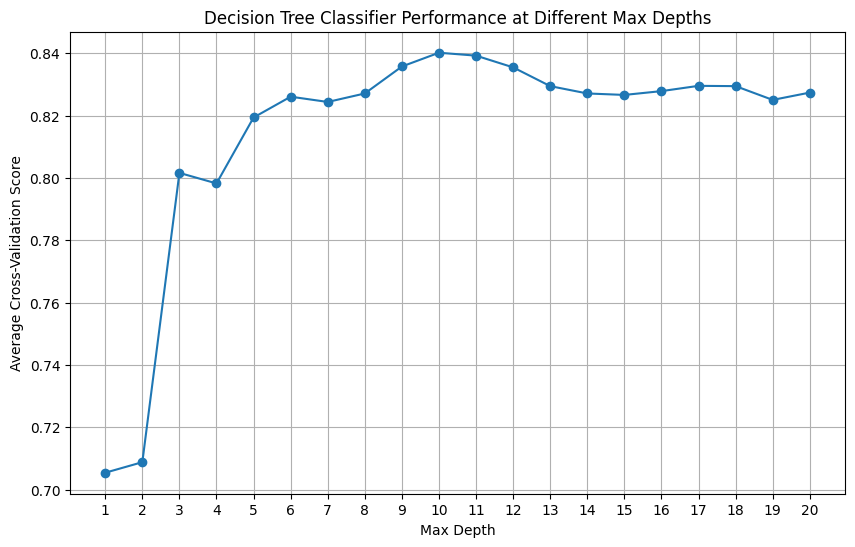


Best max depth: 10

Accuracy: 0.8509637987776211



In [ ]:
sklearn_classifiers = {"Decision Tree": DecisionTreeClassifier,
                       "Random Forest": RandomForestClassifier,
                       "Gradient Boosting": GradientBoostingClassifier}

# change this to change model type!
classifier_type = "Decision Tree"
Classifier = sklearn_classifiers[classifier_type]

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on bands data...")
# print("====================================================\n")
# bands_test, bands_pred, bands_scores = decision_tree_classifier_param_tuning(X_bands, y, Classifier)
# bands_test, bands_pred, bands_scores = decision_tree_classifier_max_depth(X_bands, y, Classifier)

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on features data...")
# print("====================================================\n")
# feats_test, feats_pred, feats_scores = decision_tree_classifier_param_tuning(X_feats, y, Classifier)
# feats_test, feats_pred, feats_scores = decision_tree_classifier_max_depth(X_feats, y, Classifier)

print("\n\n====================================================")
print(f"Running {classifier_type} classifier on complete data...")
print("====================================================\n")
# complete_test, complete_pred, complete_scores = decision_tree_classifier_param_tuning(X, y, Classifier)
complete_test, complete_pred, complete_scores = decision_tree_classifier_max_depth(X, y, Classifier)

### Analyze Results



Analyzing Gradient Boosting classifier on complete data...

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1138
           1       0.88      0.85      0.86       989

    accuracy                           0.87      2127
   macro avg       0.87      0.87      0.87      2127
weighted avg       0.87      0.87      0.87      2127



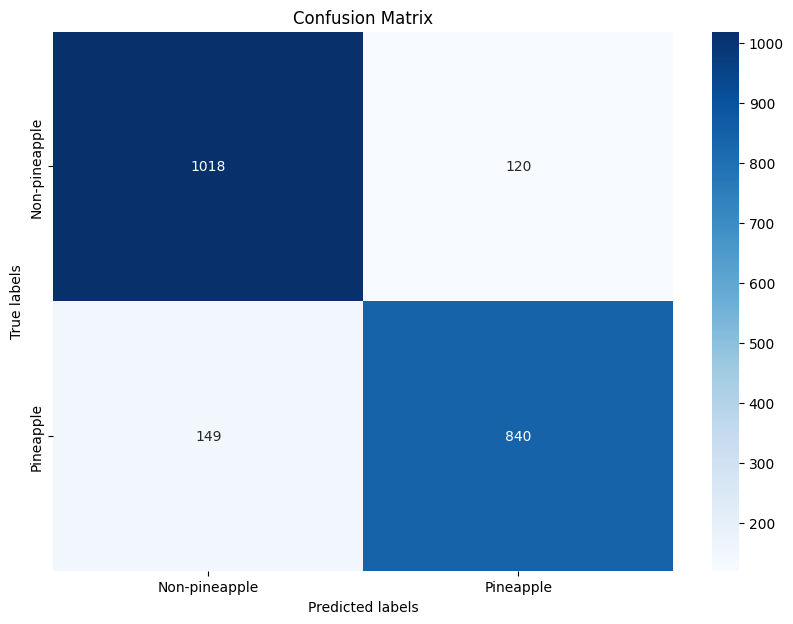

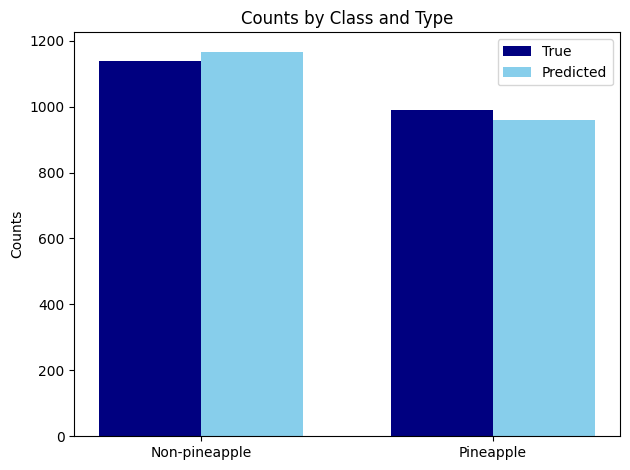

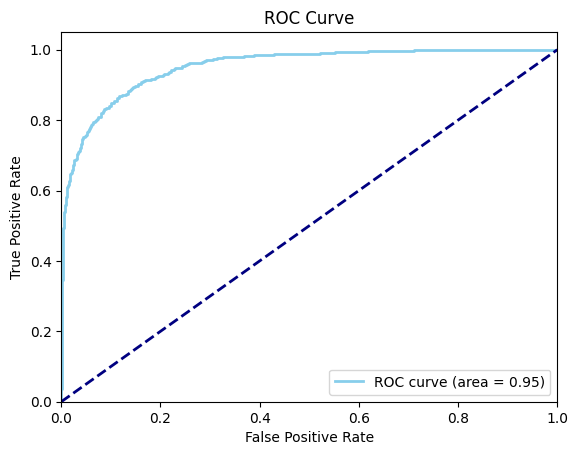

In [ ]:
# analyze_results(bands_test, bands_pred, bands_scores)
# analyze_results(feats_test, feats_pred, feats_scores)

print("\n\n====================================================")
print(f"Analyzing {classifier_type} classifier on complete data...")
print("====================================================\n")
analyze_results(complete_test, complete_pred, complete_scores)

## XGBoost

In [ ]:
import xgboost as xgb

def xgboost_classifier(X, y, max_depth):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  D_train = xgb.DMatrix(X_train, label=y_train)
  D_test = xgb.DMatrix(X_test, label=y_test)

  param = {
      'eta': 0.3,
      'max_depth': max_depth,
      'objective': 'multi:softprob',
      'num_class': 2}
  steps = 200

  model = xgb.train(param, D_train, steps)
  preds = model.predict(D_test)

  best_preds = np.asarray([np.argmax(line) for line in preds])
  print(f"Accuracy: {accuracy_score(y_test, best_preds)}")

  return y_test, best_preds



def xgboost_tune_depth(X, y):
  # tune max-depth parameter
  max_depths = range(1, 21)

  # train/test over possible depths
  for depth in max_depths:
      y_test, best_preds = xgboost_classifier(X, y, depth)
      accuracy = accuracy_score(y_test, best_preds)
      print(f"Tried max-depth of {depth}; Accuracy: {accuracy}")

**Runtimes on Complete Data**
- XGBoost: 36s, max-depth of 3 for 88.3% accuracy

In [ ]:
xgboost_tune_depth(X, y)

Tried max-depth of 1; Accuracy: 0.8631875881523272
Tried max-depth of 2; Accuracy: 0.8758815232722144
Tried max-depth of 3; Accuracy: 0.8829337094499294
Tried max-depth of 4; Accuracy: 0.8768218147625764
Tried max-depth of 5; Accuracy: 0.8688293370944993
Tried max-depth of 6; Accuracy: 0.8711800658204043
Tried max-depth of 7; Accuracy: 0.8678890456041373
Tried max-depth of 8; Accuracy: 0.8716502115655853
Tried max-depth of 9; Accuracy: 0.8692994828396803
Tried max-depth of 10; Accuracy: 0.8725905030559473
Tried max-depth of 11; Accuracy: 0.8697696285848613
Tried max-depth of 12; Accuracy: 0.8692994828396803
Tried max-depth of 13; Accuracy: 0.8754113775270334
Tried max-depth of 14; Accuracy: 0.8711800658204043
Tried max-depth of 15; Accuracy: 0.8660084626234132
Tried max-depth of 16; Accuracy: 0.8707099200752233
Tried max-depth of 17; Accuracy: 0.8707099200752233
Tried max-depth of 18; Accuracy: 0.8716502115655853
Tried max-depth of 19; Accuracy: 0.8641278796426892
Tried max-depth of 20

In [ ]:
# print("\n\n====================================================")
# print("Running xgboost classifier on bands data...")
# print("====================================================\n")
# xgb_bands_test, xgb_bands_pred = xgboost_classifier(X_bands, y, 3)

# print("\n\n====================================================")
# print("Running xgboost classifier on features data...")
# print("====================================================\n")
# xgb_feats_test, xgb_feats_pred = xgboost_classifier(X_feats, y, 3)

print("\n\n====================================================")
print("Running xgboost classifier on complete data...")
print("====================================================\n")
xgb_complete_test, xgb_complete_pred = xgboost_classifier(X, y, 3)



Running xgboost classifier on complete data...

Accuracy: 0.8829337094499294


# Non-Decision Tree Models

## Logistic Regression, K-Nearest Neighbors

### Train and Classify Classifiers

In [ ]:
def non_decision_tree_classifier(X, y, Classifier):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # create a logistic regression classifier at best depth
  ndt = Classifier()

  # fit classifier to data
  ndt.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = ndt.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = ndt.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

**Performance on Complete Data**

- Logistic Regression: 0s, 86.69488% accuracy
- K-Nearest Neighbors: 0s, 86.60085% accuracy

In [ ]:
sklearn_classifiers = {"Logistic Regression": LogisticRegression,
                       "K-Nearest Neighbors": KNeighborsClassifier}

# change this to change model type!
classifier_type = "K-Nearest Neighbors"
Classifier = sklearn_classifiers[classifier_type]

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on bands data...")
# print("====================================================\n")
# bands_test, bands_pred, bands_scores = non_decision_tree_classifier(X_bands, y, Classifier)

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on features data...")
# print("====================================================\n")
# feats_test, feats_pred, feats_scores = non_decision_tree_classifier(X_feats, y, Classifier)

print("\n\n====================================================")
print(f"Running {classifier_type} classifier on complete data...")
print("====================================================\n")
complete_test, complete_pred, complete_scores = non_decision_tree_classifier(X, y, Classifier)



Running K-Nearest Neighbors classifier on complete data...


Accuracy: 0.8660084626234132



### Analyze Results

In [ ]:
# analyze_results(bands_test, bands_pred, bands_scores)
# analyze_results(feats_test, feats_pred, feats_scores)

print("\n\n====================================================")
print(f"Analyzing {classifier_type} classifier on complete data...")
print("====================================================\n")
analyze_results(complete_test, complete_pred, complete_scores)

# Old Code

In [ ]:
def decision_tree_classifier(X, y):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # find best depth for decision tree
  best_depth = tune_max_depth(X, y)

  # create a decision tree classifier at best depth
  dt = DecisionTreeClassifier(max_depth=best_depth, random_state=0)

  # fit classifier to data
  dt.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = dt.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = dt.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy with max depth of {best_depth}: {accuracy}\n")

  return y_test, y_pred, y_scores

In [ ]:
print("\n\n====================================================")
print("Running decision tree classifier on bands data...")
print("====================================================\n")
dt_bands_test, dt_bands_pred, dt_bands_scores = decision_tree_classifier(X_bands, y)

# print("\n\n====================================================")
# print("Running decision tree classifier on features data...")
# print("====================================================\n")
# dt_feats_test, dt_feats_pred, dt_feats_scores = decision_tree_classifier(X_feats, y)

print("\n\n====================================================")
print("Running decision tree classifier on complete data...")
print("====================================================\n")
dt_complete_test, dt_complete_pred, dt_complete_scores = decision_tree_classifier(X, y)

In [ ]:
# analyze_results(dt_bands_test, dt_bands_pred, dt_bands_scores)
# analyze_results(dt_feats_test, dt_feats_pred, dt_feats_scores)

print("\n\n====================================================")
print("Analyzing decision tree classifier on complete data...")
print("====================================================\n")
analyze_results(dt_complete_test, dt_complete_pred, dt_complete_scores)



Analyzing decision tree classifier on complete data...



NameError: name 'dt_complete_test' is not defined

In [ ]:
def random_forest_classifier(X, y):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # create a decision tree classifier at best depth
  rf = RandomForestClassifier(random_state=0)

  # fit classifier to data
  rf.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = rf.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = rf.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores, rf

In [ ]:
print("\n\n====================================================")
print("Running random forest classifier on bands data...")
print("====================================================\n")
rf_bands_test, rf_bands_pred, rf_bands_scores, test = random_forest_classifier(X_bands, y)

# print("\n\n====================================================")
# print("Running random forest classifier on features data...")
# print("====================================================\n")
# rf_feats_test, rf_feats_pred, rf_feats_scores = random_forest_classifier(X_feats, y)

print("\n\n====================================================")
print("Running random forest classifier on complete data...")
print("====================================================\n")
rf_complete_test, rf_complete_pred, rf_complete_scores, rf_final = random_forest_classifier(X, y)



Running random forest classifier on bands data...


Accuracy: 0.8772919605077574



Running random forest classifier on complete data...


Accuracy: 0.8815232722143864





Analyzing random forest classifier on complete data...

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1138
           1       0.89      0.85      0.87       989

    accuracy                           0.88      2127
   macro avg       0.88      0.88      0.88      2127
weighted avg       0.88      0.88      0.88      2127



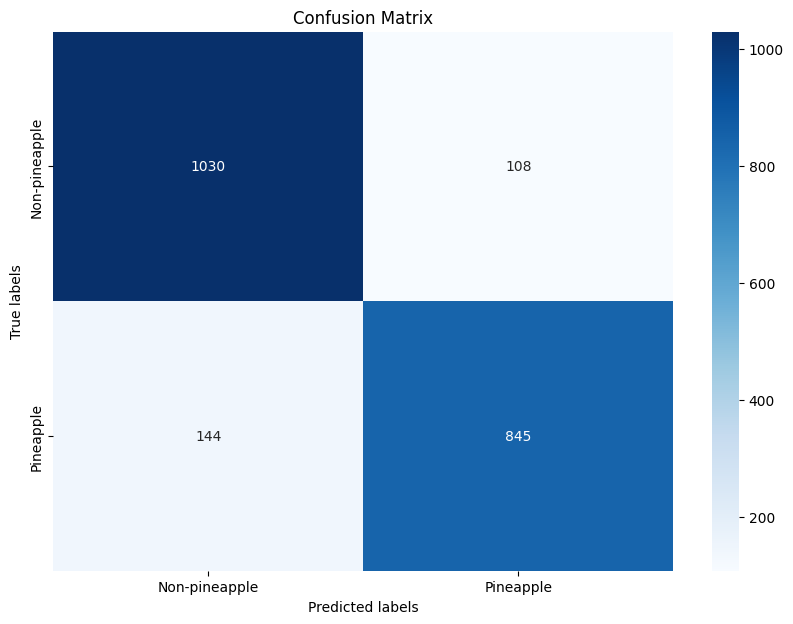

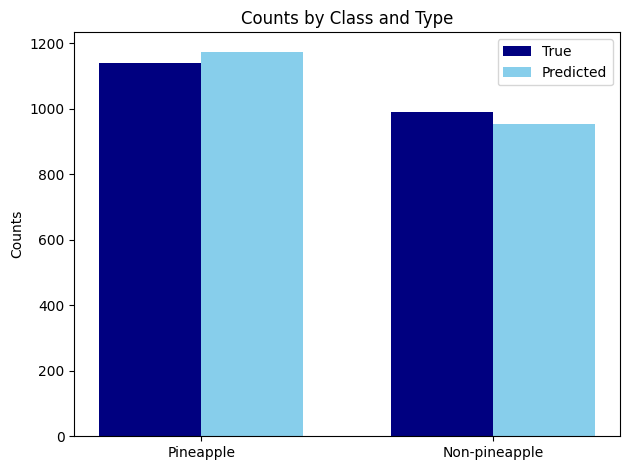

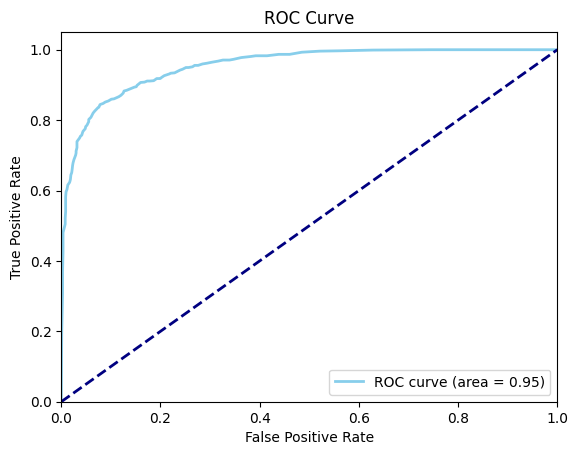

In [ ]:
# analyze_results(rf_bands_test, rf_bands_pred, rf_bands_scores)
# analyze_results(rf_feats_test, rf_feats_pred, rf_feats_scores)

print("\n\n====================================================")
print("Analyzing random forest classifier on complete data...")
print("====================================================\n")
analyze_results(rf_complete_test, rf_complete_pred, rf_complete_scores)

In [ ]:
def gradient_boosting_classifier(X, y):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # create a decision tree classifier at best depth
  rf = GradientBoostingClassifier(random_state=0, max_depth=10)

  # fit classifier to data
  rf.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = rf.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = rf.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

In [ ]:
print("\n\n====================================================")
print("Running gradient boosting classifier on bands data...")
print("====================================================\n")
gb_bands_test, gb_bands_pred, gb_bands_scores = gradient_boosting_classifier(X_bands, y)

# print("\n\n====================================================")
# print("Running gradient boosting classifier on features data...")
# print("====================================================\n")
# gb_feats_test, gb_feats_pred, gb_feats_scores = gradient_boosting_classifier(X_feats, y)

print("\n\n====================================================")
print("Running gradient boosting classifier on complete data...")
print("====================================================\n")
gb_complete_test, gb_complete_pred, gb_complete_scores = gradient_boosting_classifier(X, y)



Running gradient boosting classifier on bands data...


Accuracy: 0.8758815232722144



Running gradient boosting classifier on complete data...


Accuracy: 0.8777621062529384





Analyzing gradient boosting classifier on complete data...

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1138
           1       0.88      0.86      0.87       989

    accuracy                           0.88      2127
   macro avg       0.88      0.88      0.88      2127
weighted avg       0.88      0.88      0.88      2127



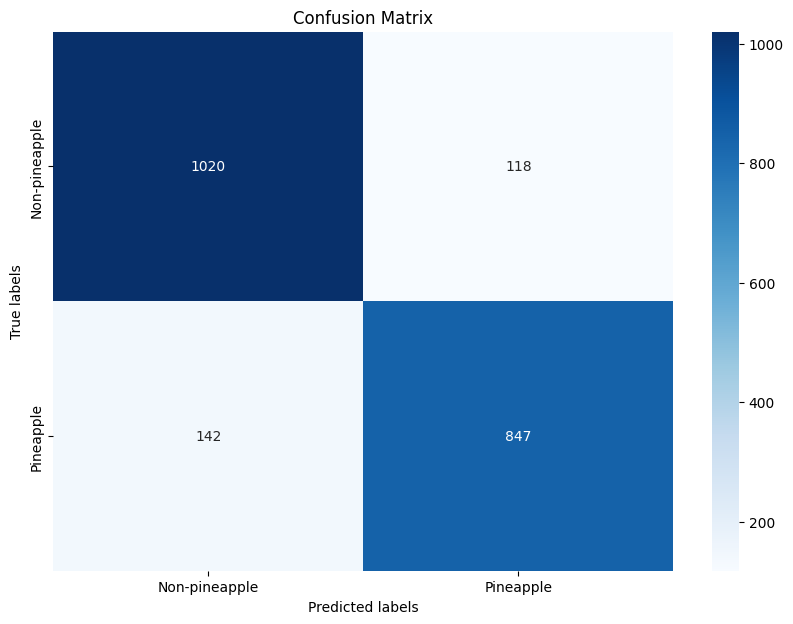

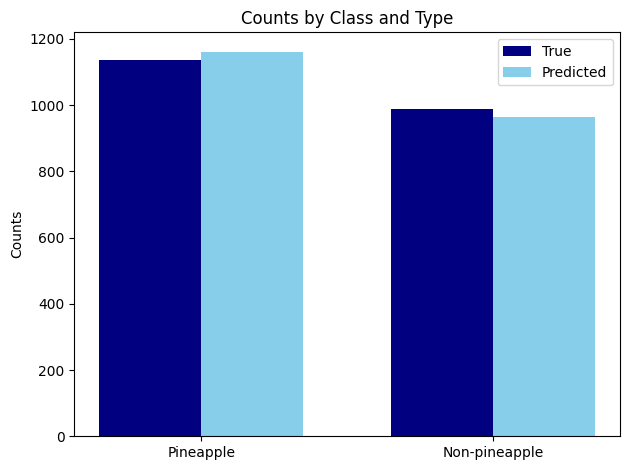

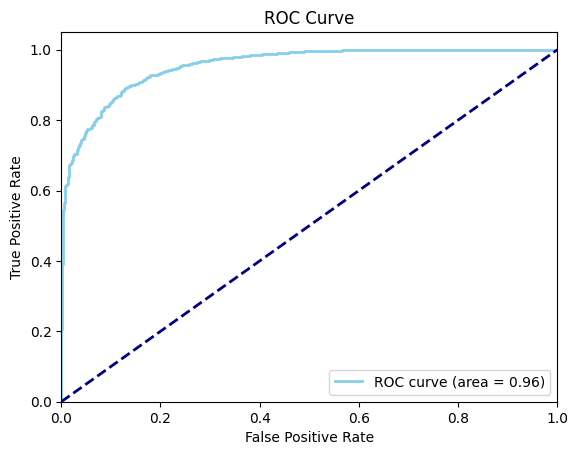

In [ ]:
# analyze_results(gb_bands_test, gb_bands_pred, gb_bands_scores)
# analyze_results(gb_feats_test, gb_feats_pred, gb_feats_scores)

print("\n\n====================================================")
print("Analyzing gradient boosting classifier on complete data...")
print("====================================================\n")
analyze_results(gb_complete_test, gb_complete_pred, gb_complete_scores)

In [ ]:
def non_decision_tree_classifier(X, y, Classifier):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # create a logistic regression classifier at best depth
  ndt = Classifier()

  # fit classifier to data
  ndt.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = ndt.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = ndt.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

In [ ]:
sklearn_classifiers = {"Logistic Regression": LogisticRegression,
                       "K-Nearest Neighbors": KNeighborsClassifier}

# change this to change model type!
classifier_type = "Logistic Regression"
Classifier = sklearn_classifiers[classifier_type]

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on bands data...")
# print("====================================================\n")
# bands_test, bands_pred, bands_scores = non_decision_tree_classifier(X_bands, y, Classifier)

# print("\n\n====================================================")
# print(f"Running {classifier_type} classifier on features data...")
# print("====================================================\n")
# feats_test, feats_pred, feats_scores = non_decision_tree_classifier(X_feats, y, Classifier)

print("\n\n====================================================")
print(f"Running {classifier_type} classifier on complete data...")
print("====================================================\n")
complete_test, complete_pred, complete_scores = non_decision_tree_classifier(X, y, Classifier)

In [ ]:
# analyze_results(bands_test, bands_pred, bands_scores)
# analyze_results(feats_test, feats_pred, feats_scores)

print("\n\n====================================================")
print(f"Analyzing {classifier_type} classifier on complete data...")
print("====================================================\n")
analyze_results(complete_test, complete_pred, complete_scores)

In [ ]:
print("\n\n====================================================")
print("Running logistic regression classifier on bands data...")
print("====================================================\n")
lg_bands_test, lg_bands_pred, lg_bands_scores = non_decision_tree(X_bands, y)

# print("\n\n====================================================")
# print("Running logistic regression classifier on features data...")
# print("====================================================\n")
# lg_feats_test, lg_feats_pred, lg_feats_scores = logistic_regression_classifier(X_feats, y)

print("\n\n====================================================")
print("Running logistic regression classifier on complete data...")
print("====================================================\n")
lg_complete_test, lg_complete_pred, lg_complete_scores = logistic_regression_classifier(X, y)



Running logistic regression classifier on bands data...



NameError: name 'non_decision_tree' is not defined

In [ ]:
def k_nearest_neighbors_classifier(X, y):
  # 80-20 split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

  # create a logistic regression classifier at best depth
  knn = KNeighborsClassifier()

  # fit classifier to data
  knn.fit(X_train, y_train)

  # get probability of data point being pineapple
  y_scores = knn.predict_proba(X_test)[:, 1]

  # predict labels of test set
  y_pred = knn.predict(X_test)

  # display accuracy of classifier
  accuracy = accuracy_score(y_test, y_pred)
  print(f"\nAccuracy: {accuracy}\n")

  return y_test, y_pred, y_scores

In [ ]:
print("\n\n====================================================")
print("Running KNN classifier on bands data...")
print("====================================================\n")
knn_bands_test, knn_bands_pred, knn_bands_scores = k_nearest_neighbors_classifier(X_bands, y)

# print("\n\n====================================================")
# print("Running KNN classifier on features data...")
# print("====================================================\n")
# knn_feats_test, knn_feats_pred, knn_feats_scores = k_nearest_neighbors_classifier(X_feats, y)

print("\n\n====================================================")
print("Running KNN classifier on complete data...")
print("====================================================\n")
knn_complete_test, knn_complete_pred, knn_complete_scores = k_nearest_neighbors_classifier(X, y)



Running KNN classifier on bands data...


Accuracy: 0.8608368594264222



Running KNN classifier on complete data...


Accuracy: 0.8660084626234132





Analyzing KNN classifier on complete data...

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1138
           1       0.86      0.85      0.85       989

    accuracy                           0.87      2127
   macro avg       0.87      0.86      0.87      2127
weighted avg       0.87      0.87      0.87      2127



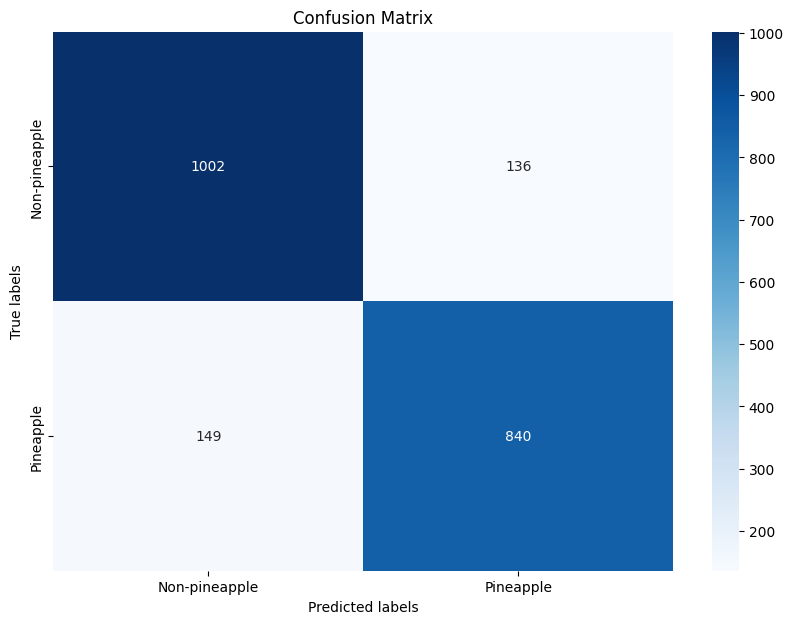

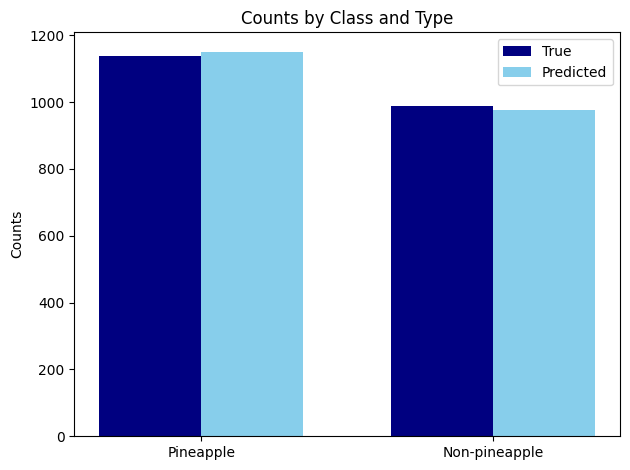

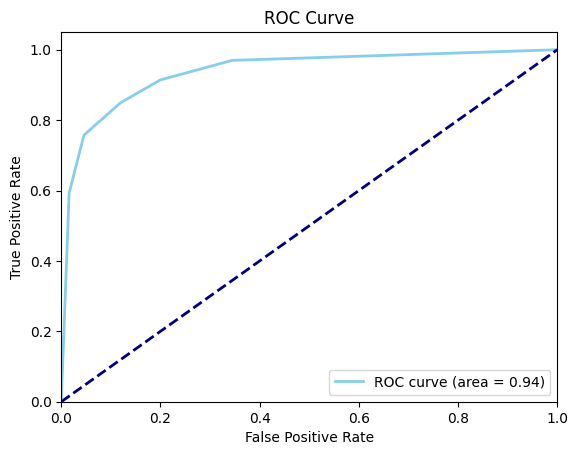

In [ ]:
# analyze_results(knn_bands_test, knn_bands_pred, knn_bands_scores)
# analyze_results(knn_feats_test, knn_feats_pred, knn_feats_scores)

print("\n\n====================================================")
print("Analyzing KNN classifier on complete data...")
print("====================================================\n")
analyze_results(knn_complete_test, knn_complete_pred, knn_complete_scores)